In [40]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

df_full_user = pd.read_csv("../preprosscedDataSet.csv")
df_games = pd.read_csv("../full_api_preprocessing.csv")

In [41]:
df_user = pd.DataFrame(df_full_user[["user_id","game_name"," time_is_play", "06_time_100"]])
df_user.head()

,user_id,game_name,time_is_play,06_time_100
0,5250,Alien Swarm,5.9,54486.0
1,76767,Alien Swarm,1.8,54486.0
2,298950,Alien Swarm,2.6,54486.0
3,975449,Alien Swarm,10.8,54486.0
4,1364546,Alien Swarm,1.9,54486.0


Shooter                       51
Platform                      30
Role-playing (RPG)            19
Puzzle                        12
Real Time Strategy (RTS)       9
Point-and-click                7
Fighting                       7
Simulator                      6
Strategy                       5
Adventure                      5
Racing                         5
Hack and slash/Beat 'em up     2
Sport                          1
Turn-based strategy (TBS)      1
Music                          1
Name: genre1, dtype: int64


<AxesSubplot: ylabel='genre1'>

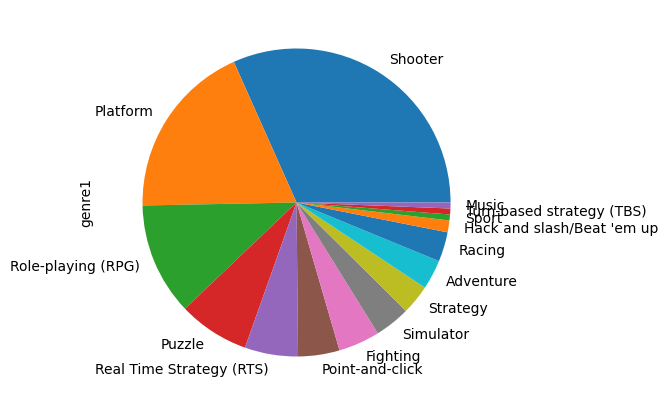

In [42]:
print(pd.merge(df_user[df_user["user_id"]==975449], df_games, left_on="game_name", right_on="01_game_name", how="inner")["genre1"].value_counts())
pd.merge(df_user[df_user["user_id"]==975449], df_games, left_on="game_name", right_on="01_game_name", how="inner")["genre1"].value_counts().plot.pie(figsize=(5, 5))

In [43]:
df_user["rating_reco"] = df_user[" time_is_play"]/df_user["06_time_100"]
df_user["rating_reco"] = df_user["rating_reco"].replace(-np.inf,0)
df_user["rating_reco"] = df_user["rating_reco"].replace(np.inf,0)
df_user.drop(columns=[" time_is_play", "06_time_100"], inplace=True)
df_user = df_user.dropna()
df_user.shape
df_user.describe()

,user_id,rating_reco
count,9.792400e+04,97924.000000
mean,1.041839e+08,0.000094
std,7.361022e+07,0.000578
min,5.250000e+03,0.000000
25%,4.541169e+07,0.000001
50%,8.691201e+07,0.000014
75%,1.565879e+08,0.000057
max,3.099031e+08,0.086613


In [44]:
df_user = df_user[df_user["rating_reco"]<0.000100]
df_user = df_user[df_user["rating_reco"]>0.0000001]
df_user["rating_reco_100"] = (df_user["rating_reco"]*100)/df_user["rating_reco"].max()
df_user.rename(columns={"rating_reco_100": "raw_ratings"}, inplace=True)
df_user.describe()

,user_id,rating_reco,raw_ratings
count,6.416200e+04,6.416200e+04,64162.000000
mean,1.019419e+08,2.204680e-05,22.053221
std,7.339141e+07,2.381643e-05,23.823359
min,5.250000e+03,1.019466e-07,0.101976
25%,4.368463e+07,3.843390e-06,3.844509
50%,8.549786e+07,1.355014e-05,13.554080
75%,1.542307e+08,3.247586e-05,32.485312
max,3.099031e+08,9.997089e-05,100.000000


In [56]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(df_user[['user_id', 'game_name', 'raw_ratings']], reader)

trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [57]:
svd = SVD(random_state=42)
svd.fit(trainset)

In [58]:
unique_games = df_user["game_name"].unique()
def make_predictions(model, user_id, top_x = None):
    res = []
    for game in unique_games:
        res.append((game, model.predict(user_id, game).est))
    res = pd.DataFrame(data=res, columns = ["game_name", "ranking"]).sort_values(by="ranking", ascending=False)
    if(top_x):
        res = res.iloc[:top_x]
    return res

In [62]:
make_predictions(svd, 99264709)

,game_name,ranking
695,Car Mechanic Simulator 2015,93.665599
467,This War of Mine,92.767596
1258,Polarity,92.165560
12,Half-Life Blue Shift,83.160243
300,Antichamber,76.984037
122,Fallout 4,73.721672
413,VVVVVV,73.245779
672,Skullgirls,71.472401
205,The Binding of Isaac,70.733544
35,Borderlands 2,70.070796
